**<div style="font-size:25px; color: #4d81b0;">Importing Libraries</div>**

In [1]:
pip install nlpaug

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 6.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nlpaug.augmenter.word as naw
import os
import re
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import BertForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
import tensorflow as tf
from torch import nn
label_encoder = LabelEncoder()
aug = naw.SynonymAug(aug_src='wordnet')
import nltk
nltk.download('averaged_perceptron_tagger_eng')

plt.style.use('ggplot')
import warnings 
warnings.filterwarnings('ignore')

2025-05-02 21:44:48.854870: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746222289.302515      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746222289.427852      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


In [3]:
data = pd.read_csv('/kaggle/input/sentiment-analysis-for-mental-health/Combined Data.csv')
data.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  53043 non-null  int64 
 1   statement   52681 non-null  object
 2   status      53043 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


In [5]:
data.drop(columns=['Unnamed: 0'], inplace=True)
data.head()

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


**<div style="font-size:25px; color: #4d81b0;">Data Cleaning</div>**

In [6]:
data['status'].value_counts()

status
Normal                  16351
Depression              15404
Suicidal                10653
Anxiety                  3888
Bipolar                  2877
Stress                   2669
Personality disorder     1201
Name: count, dtype: int64

In [7]:
data.isnull().sum()

statement    362
status         0
dtype: int64

In [8]:
data.dropna(inplace=True)

In [9]:
data.duplicated().sum()

1588

In [10]:
data.drop_duplicates(inplace = True)

In [11]:
data['status'].value_counts()

status
Normal                  16040
Depression              15094
Suicidal                10644
Anxiety                  3623
Bipolar                  2501
Stress                   2296
Personality disorder      895
Name: count, dtype: int64

In [12]:
data = data[data['status']!='Personality disorder']

In [13]:
len(data)

50198

In [14]:
data['status'].value_counts()

status
Normal        16040
Depression    15094
Suicidal      10644
Anxiety        3623
Bipolar        2501
Stress         2296
Name: count, dtype: int64

<Axes: xlabel='count', ylabel='status'>

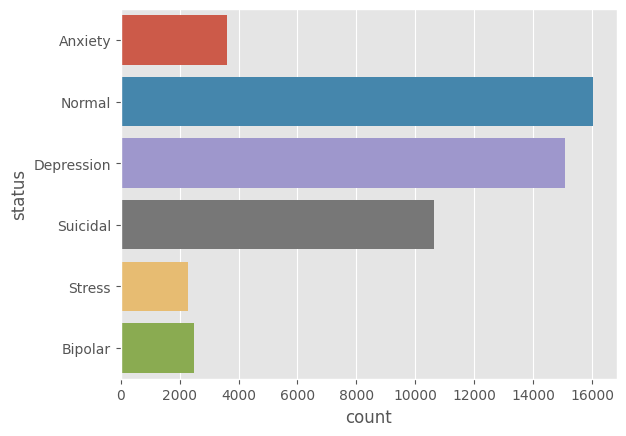

In [15]:
sns.countplot(data=data, y='status')

In [16]:
anxiety_df = data[data['status']=='Anxiety']
bipolar_df = data[data['status']=='Bipolar']
stress_df = data[data['status']=='Stress']

for i in anxiety_df['statement']:
    new_text = aug.augment(i)[0]
    new_record = {
    'status' : 'Anxiety',
    'statement' : new_text
    }
    new_df = pd.DataFrame([new_record])
    data = pd.concat([data, new_df], ignore_index=True)

for i in bipolar_df['statement']:
    new_text = aug.augment(i)[0]
    new_record = {
    'status' : 'Bipolar',
    'statement' : new_text
    }
    new_df = pd.DataFrame([new_record])
    data = pd.concat([data, new_df], ignore_index=True)

for i in stress_df['statement']:
    new_text = aug.augment(i)[0]
    new_record = {
    'status' : 'Stress',
    'statement' : new_text
    }
    new_df = pd.DataFrame([new_record])
    data = pd.concat([data, new_df], ignore_index=True)


In [17]:
data['status'].value_counts()

status
Normal        16040
Depression    15094
Suicidal      10644
Anxiety        7246
Bipolar        5002
Stress         4592
Name: count, dtype: int64

<Axes: xlabel='count', ylabel='status'>

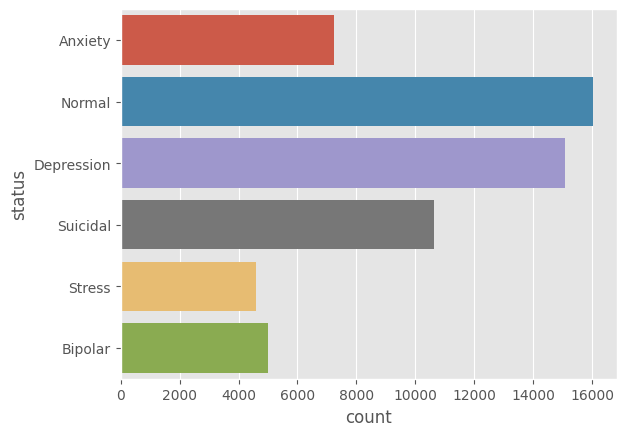

In [18]:
sns.countplot(data=data, y='status')

**<div style="font-size:25px; color: #4d81b0;">Data Preprocessing</div>**

In [19]:
def has_tags(text): # Check if their exist tags in the data
    pattern = re.compile(r'<.*?>')
    match = re.search(pattern, text)
    return match is not None
    
def tokenize(text): # tokenize text into words
    ans = word_tokenize(text)
    return ans

def remove_punc(text): # remove punctuations from the text
    ans = [word for word in text if word not in punctuation]
    return ans

def remove_ex(text): # remove dots from the text
    pattern=re.compile(r'[^\x00-\x7F]+')
    return pattern.sub('', text)

def remove_stop(text): # remove stopwords from the text
    stops = set(stopwords.words('english'))
    ans = " ".join([word for word in text.split() if word not in stops])
    return ans

def stemmer(text): # apply stemming on text
    ans = [ps.stem(word) for word in text]
    return ans

def lemmatizer(text): # apply lemmatization on text
    ans = [lemm.lemmatize(word) for word in text]
    return ans

def remove_links(text): # remove links from the text
    return re.sub(r'https?:\/\/(.[\r\n])', '', text, flags=re.MULTILINE)

def remove_tags(text): # remove html tags
    pattern = re.compile(r'<.*?>')     
    return pattern.sub('', text)

def again(text): # reverse tokenization
    ans = " ".join([word for word in text])
    return ans

def count_punc(text): # return count of characters in the text
    count = sum([1 for char in text if char in punctuation])
    return round( count/(len(text) - text.count(" ")),3)*100

def tokenize_function(examples):
    return tokenizer(
        examples['statement'],
        padding='max_length',
        truncation=True,
        max_length=128
    )

In [20]:
data['statement'].apply(has_tags).sum()

142

In [21]:
data['statement'] = data['statement'].str.lower()
data.head()

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"all wrong, back off dear, forward doubt. stay ...",Anxiety
3,i've shifted my focus to something else but i'...,Anxiety
4,"i'm restless and restless, it's been a month n...",Anxiety


In [22]:
data['statement'] = data['statement'].apply(lambda x: remove_tags(x))
data['statement'].head()

0                                           oh my gosh
1    trouble sleeping, confused mind, restless hear...
2    all wrong, back off dear, forward doubt. stay ...
3    i've shifted my focus to something else but i'...
4    i'm restless and restless, it's been a month n...
Name: statement, dtype: object

In [23]:
data['statement'] = data['statement'].apply(lambda x: tokenize(x))
data['statement'].head()

0                                       [oh, my, gosh]
1    [trouble, sleeping, ,, confused, mind, ,, rest...
2    [all, wrong, ,, back, off, dear, ,, forward, d...
3    [i, 've, shifted, my, focus, to, something, el...
4    [i, 'm, restless, and, restless, ,, it, 's, be...
Name: statement, dtype: object

In [24]:
data['statement'] = data['statement'].apply(lambda x: remove_punc(x))
data['statement'].head()

0                                       [oh, my, gosh]
1    [trouble, sleeping, confused, mind, restless, ...
2    [all, wrong, back, off, dear, forward, doubt, ...
3    [i, 've, shifted, my, focus, to, something, el...
4    [i, 'm, restless, and, restless, it, 's, been,...
Name: statement, dtype: object

In [25]:
data['statement'] = data['statement'].apply(lambda x: again(x))
data['statement'].head()

0                                           oh my gosh
1    trouble sleeping confused mind restless heart ...
2    all wrong back off dear forward doubt stay in ...
3    i 've shifted my focus to something else but i...
4    i 'm restless and restless it 's been a month ...
Name: statement, dtype: object

In [26]:
data['statement'] = data['statement'].apply(lambda x: remove_stop(x))
data['statement'].head()

0                                              oh gosh
1    trouble sleeping confused mind restless heart ...
2    wrong back dear forward doubt stay restless re...
3    've shifted focus something else 'm still worried
4               'm restless restless 's month boy mean
Name: statement, dtype: object

In [27]:
data['statement'] = data['statement'].apply(lambda x: remove_ex(x))
data['statement'].head()

0                                              oh gosh
1    trouble sleeping confused mind restless heart ...
2    wrong back dear forward doubt stay restless re...
3    've shifted focus something else 'm still worried
4               'm restless restless 's month boy mean
Name: statement, dtype: object

In [28]:
data.head(10)

,statement,status
0,oh gosh,Anxiety
1,trouble sleeping confused mind restless heart ...,Anxiety
2,wrong back dear forward doubt stay restless re...,Anxiety
3,'ve shifted focus something else 'm still worried,Anxiety
4,'m restless restless 's month boy mean,Anxiety
5,every break must nervous like something wrong ...,Anxiety
6,feel scared anxious may family us protected,Anxiety
7,ever felt nervous n't know,Anxiety
8,n't slept well 2 days 's like 'm restless huh,Anxiety
9,'m really worried want cry,Anxiety


In [29]:
data = data.sample(frac=1).reset_index(drop=True)
data.head(10)

,statement,status
0,heading altrincham hour install,Normal
1,see medico new diagnosed character stress diso...,Stress
2,topamax side effects 6 months 've lost much ha...,Bipolar
3,share ni-ki odng templates,Normal
4,need near death experience snap depressive fog...,Depression
5,feel like getting closer giving everyday help ...,Depression
6,things happen course life quite normal somethi...,Normal
7,courage get gun shoot feel like life pointless...,Suicidal
8,crazy think many people undervalue significanc...,Suicidal
9,got diagnosis generalized anxiety disorder wa ...,Depression


In [30]:
data['statement'].iloc[9]

'got diagnosis generalized anxiety disorder wa optimistic relieved living condition many year completely unaware diagnosis wa spark hope perhaps one day able recover proper combination therapy medication year later must admit feel exhausted life really depressing live knowledge constantly alert condition spiral get worse yes treatment help needing continually use cbt meditation grounding technique etc thing normal people without difficulty infuriating feel like nearly talked enough mental health circle anxiety depression portrayed often condition fixed right cocktail also sometimes life long condition exhaust loved one know feeling bitter today'

In [31]:
data['encoded'] = label_encoder.fit_transform(data['status'])
data.head(10)

,statement,status,encoded
0,heading altrincham hour install,Normal,3
1,see medico new diagnosed character stress diso...,Stress,4
2,topamax side effects 6 months 've lost much ha...,Bipolar,1
3,share ni-ki odng templates,Normal,3
4,need near death experience snap depressive fog...,Depression,2
5,feel like getting closer giving everyday help ...,Depression,2
6,things happen course life quite normal somethi...,Normal,3
7,courage get gun shoot feel like life pointless...,Suicidal,5
8,crazy think many people undervalue significanc...,Suicidal,5
9,got diagnosis generalized anxiety disorder wa ...,Depression,2


In [32]:
data['status'].unique()

array(['Normal', 'Stress', 'Bipolar', 'Depression', 'Suicidal', 'Anxiety'],
      dtype=object)

In [33]:
data['encoded'].unique()

array([3, 4, 1, 2, 5, 0])

In [34]:
os.makedirs('/kaggle/working/results', exist_ok = True)

In [35]:
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# train_dataset = Dataset.from_pandas(train_df)
# val_dataset = Dataset.from_pandas(val_df)
# test_dataset = Dataset.from_pandas(test_df)

# tokenized_train = train_dataset.map(tokenize_function, batched=True)
# tokenized_val = val_dataset.map(tokenize_function, batched=True)
# tokenized_test = test_dataset.map(tokenize_function, batched=True)

# model = BertForSequenceClassification.from_pretrained(
#     'bert-base-uncased',
#     num_labels=6
# )

# training_args = TrainingArguments(
#     output_dir='/kaggle/working/results',
#     eval_strategy='epoch',
#     learning_rate=0.00001,
#     per_device_train_batch_size=16,
#     per_device_eval_batch_size=16,
#     num_train_epochs=3,
#     weight_decay=0.01,
#     save_strategy='epoch',
#     load_best_model_at_end=True
# )

# class_weights = compute_class_weight(
#     class_weight='balanced',
#     classes=np.unique(train_df['encoded']),
#     y=train_df['encoded']
# )

# class CustomTrainer(Trainer):
#     def compute_loss(self, model, inputs, return_outputs=False):
#         labels = inputs.get('labels')
#         outputs = model(**inputs)
#         logits = outputs.get('logits')
#         loss_fct = nn.CrossEntropyLoss(weight=torch.tensor(class_weights).float().to('cuda'))
#         loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
#         return (loss, outputs) if return_outputs else loss

**<div style="font-size:25px; color: #4d81b0;">Model Building and Training</div>**

In [36]:
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf

# Encode labels
labels = label_encoder.fit_transform(data['status'])
class_names = label_encoder.classes_ 
num_classes = 6

# Train/validation split
X_train, X_val, y_train, y_val = train_test_split(
    data['statement'], labels, test_size=0.2, random_state=42
)

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_texts(texts, max_length=128):
    return tokenizer(
        texts.tolist(),
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='tf'
    )

train_encodings = tokenize_texts(X_train)
val_encodings = tokenize_texts(X_val)

# Dataset creation
train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': train_encodings['input_ids'],
        'attention_mask': train_encodings['attention_mask']
    }, y_train)).shuffle(1000).batch(16)

val_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': val_encodings['input_ids'],
        'attention_mask': val_encodings['attention_mask']
    }, y_val)).batch(16)

# Load BERT model
model = TFBertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=num_classes
)

# Compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=2, 
    restore_best_weights=True
)

# ReduceLROnPlateau callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,       # reduce learning rate by half
    patience=1,       # wait 1 epoch without improvement
    min_lr=1e-7,      # lower bound on learning rate
    verbose=1
)

# Train with callbacks
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,  # you can now set this higher; early stopping will control stopping
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate
results = model.evaluate(val_dataset)
print(f'Validation accuracy: {results[1]*100:.2f}%')

# Save if needed
model.save_pretrained('mental_health_bert')
tokenizer.save_pretrained('mental_health_bert')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

I0000 00:00:1746222466.380677      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746222466.381411      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/20


I0000 00:00:1746222524.102754      68 service.cc:148] XLA service 0x7da14869bcd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746222524.104448      68 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1746222524.104468      68 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1746222524.241283      68 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1746222524.421567      68 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2931/2931 [==============================] - 1354s 443ms/step - loss: 0.6812 - accuracy: 0.7399 - val_loss: 0.5246 - val_accuracy: 0.7962 - lr: 2.0000e-05
Epoch 2/20
2931/2931 [==============================] - 1299s 443ms/step - loss: 0.4316 - accuracy: 0.8302 - val_loss: 0.4744 - val_accuracy: 0.8151 - lr: 2.0000e-05
Epoch 3/20
2931/2931 [==============================] - ETA: 0s - loss: 0.2989 - accuracy: 0.8809
Epoch 3: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
2931/2931 [==============================] - 1298s 443ms/step - loss: 0.2989 - accuracy: 0.8809 - val_loss: 0.5493 - val_accuracy: 0.8063 - lr: 2.0000e-05
Epoch 4/20
2931/2931 [==============================] - ETA: 0s - loss: 0.1711 - accuracy: 0.9342
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
733/733 [==============================] - 107s 145ms/step - loss: 0.4744 - accuracy: 0.8151
Validation accuracy: 81.51%


('mental_health_bert/tokenizer_config.json',
 'mental_health_bert/special_tokens_map.json',
 'mental_health_bert/vocab.txt',
 'mental_health_bert/added_tokens.json')

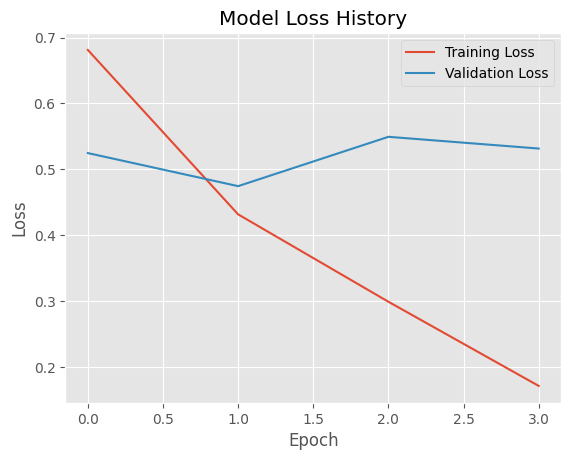

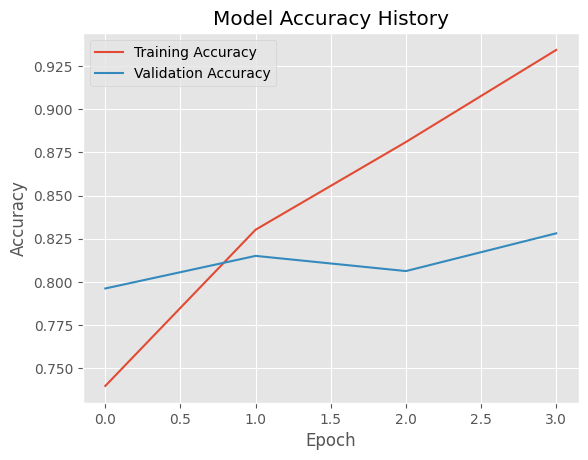

In [37]:
import matplotlib.pyplot as plt
from tensorflow import keras

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss History')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

if 'accuracy' in history.history:
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy History')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

In [38]:
def predict(text):
    inputs = tokenizer(
        text,
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors='tf'
    )
    outputs = model(inputs)
    probs = tf.nn.softmax(outputs.logits, axis=-1)
    return class_names[tf.argmax(probs, axis=-1).numpy()[0]]

print(predict("I feel constantly overwhelmed and anxious"))

Anxiety


In [39]:
from sklearn.metrics import classification_report

logits = model.predict(val_dataset).logits
y_pred = tf.argmax(logits, axis=1).numpy()

print(classification_report(y_val, y_pred, target_names=class_names))

733/733 [==============================] - 109s 144ms/step
              precision    recall  f1-score   support

     Anxiety       0.92      0.85      0.88      1450
     Bipolar       0.88      0.87      0.87      1046
  Depression       0.75      0.70      0.73      3012
      Normal       0.94      0.93      0.94      3145
      Stress       0.78      0.77      0.78       950
    Suicidal       0.66      0.77      0.71      2121

    accuracy                           0.82     11724
   macro avg       0.82      0.82      0.82     11724
weighted avg       0.82      0.82      0.82     11724

